#**Практическое задание №1**

Установка необходимых пакетов:

In [1]:
!pip install -q tqdm
!pip install --upgrade --no-cache-dir gdown

Монтирование Вашего Google Drive к текущему окружению:

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


Константы, которые пригодятся в коде далее, и ссылки (gdrive идентификаторы) на предоставляемые наборы данных:

In [3]:
EVALUATE_ONLY = False
TEST_ON_LARGE_DATASET = True
TISSUE_CLASSES = ('ADI', 'BACK', 'DEB', 'LYM', 'MUC', 'MUS', 'NORM', 'STR', 'TUM')
DATASETS_LINKS = {
    'train': '1EkQL97xSiNgjYOE3rHuTfOX9Vd2841P1',
    'train_small': '1yFYg7RuOGofOJs2exrOxlsyZSteDPb8F',
    'train_tiny': '1cXyZyfHin8Xq5jMR_FW9dmkuqoteJnzX',
    'test': '1pCiol3n3Tj4jkPW-Sf6muqhGxkCE2LlK',
    'test_small': '1mmfoAtfIhcjhGE5UGhBHpCnL6HSVRSSP',
    'test_tiny': '18e8gzRxqBLGHoyTwRwO3SCf_kAITLE07'
}

Импорт необходимых зависимостей:

In [4]:
from pathlib import Path
import numpy as np
from typing import List
from tqdm.notebook import tqdm
from time import sleep
from PIL import Image
import IPython.display
from sklearn.metrics import balanced_accuracy_score
import gdown
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader

---
### Класс Dataset

Предназначен для работы с наборами данных, обеспечивает чтение изображений и соответствующих меток, а также формирование пакетов (батчей).

In [23]:
class ImgDataset(Dataset):

    def __init__(self, name, transform=None):
        self.name = name
        self.is_loaded = False
        url = f"https://drive.google.com/uc?id={DATASETS_LINKS[name]}"
        # url = f"{DATASETS_LINKS[name]}"
        output = f'{name}.npz'
        gdown.download(url, output, quiet=False)
        print(f'Loading dataset {self.name} from npz.')
        np_obj = np.load(f'{name}.npz')
        self.images = np_obj['data']
        self.labels = np_obj['labels']
        self.n_files = self.images.shape[0]
        self.is_loaded = True

        self.len_ = len(self.labels)

        #LBL4
        self.transform = transform
        print(f'Done. Dataset {name} consists of {self.n_files} images.')

    def image(self, i):
        # read i-th image in dataset and return it as numpy array
        if self.is_loaded:
            return self.images[i, :, :, :]

    def images_seq(self, n=None):
        # sequential access to images inside dataset (is needed for testing)
        for i in range(self.n_files if not n else n):
            yield self.image(i)

    def random_image_with_label(self):
        # get random image with label from dataset
        i = np.random.randint(self.n_files)
        return self.transform(image=self.images[i])['image'], self.labels[i]

    def random_batch_with_labels(self, n):
        # create random batch of images with labels (is needed for training)
        indices = np.random.choice(self.n_files, n)
        imgs = []
        for i in indices:
            img = self.transform(image=self.images[i])['image']
            imgs.append(self.transform(image=self.images[i])['image'])
        logits = np.array([self.labels[i] for i in indices])
        return np.stack(imgs), logits

    def image_with_label(self, i: int):
        # return i-th image with label from dataset
        return self.image(i), self.labels[i]

    def __len__(self):
        return self.len_

    def __getitem__(self, index):
        if (self.transform != None):
            return self.transform(image=self.images[index])['image'], self.labels[index]
        return self.images[index], self.labels[index]

### Пример использвания класса Dataset
Загрузим обучающий набор данных, получим произвольное изображение с меткой. После чего визуализируем изображение, выведем метку. В будущем, этот кусок кода можно закомментировать или убрать.

Downloading...
From (uriginal): https://drive.google.com/uc?id=1cXyZyfHin8Xq5jMR_FW9dmkuqoteJnzX
From (redirected): https://drive.google.com/uc?id=1cXyZyfHin8Xq5jMR_FW9dmkuqoteJnzX&confirm=t&uuid=a6213dee-de31-4bbf-a41b-eccdbbd1b213
To: /content/train_tiny.npz
100%|██████████| 105M/105M [00:01<00:00, 90.5MB/s]


Loading dataset train_tiny from npz.
Done. Dataset train_tiny consists of 900 images.

Got numpy array of shape (224, 224, 3), and label with code 4.
Label code corresponds to MUC class.


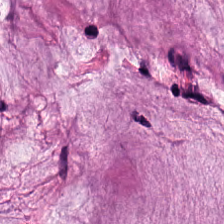

In [6]:
d_train_tiny = ImgDataset('train_tiny')

img, lbl = d_train_tiny.random_image_with_label()
print()
print(f'Got numpy array of shape {img.shape}, and label with code {lbl}.')
print(f'Label code corresponds to {TISSUE_CLASSES[lbl]} class.')

pil_img = Image.fromarray(img)
IPython.display.display(pil_img)

In [24]:
d_train_r = ImgDataset('train_tiny', train_transform_alb)

Downloading...
From (uriginal): https://drive.google.com/uc?id=1cXyZyfHin8Xq5jMR_FW9dmkuqoteJnzX
From (redirected): https://drive.google.com/uc?id=1cXyZyfHin8Xq5jMR_FW9dmkuqoteJnzX&confirm=t&uuid=d46c9345-39a6-4340-b202-fcdc677cacff
To: /content/train_tiny.npz
100%|██████████| 105M/105M [00:01<00:00, 103MB/s]


Loading dataset train_tiny from npz.
Done. Dataset train_tiny consists of 900 images.


In [7]:
len(d_train_tiny)

900

---
### Класс Metrics

Реализует метрики точности, используемые для оценивания модели:
1. точность,
2. сбалансированную точность.

In [8]:
class Metrics:

    @staticmethod
    def accuracy(gt: List[int], pred: List[int]):
        assert len(gt) == len(pred), 'gt and prediction should be of equal length'
        return sum(int(i[0] == i[1]) for i in zip(gt, pred)) / len(gt)

    @staticmethod
    def accuracy_balanced(gt: List[int], pred: List[int]):
        return balanced_accuracy_score(gt, pred)

    @staticmethod
    def print_all(gt: List[int], pred: List[int], info: str):
        print(f'metrics for {info}:')
        print('\t accuracy {:.4f}:'.format(Metrics.accuracy(gt, pred)))
        print('\t balanced accuracy {:.4f}:'.format(Metrics.accuracy_balanced(gt, pred)))

---
### Класс Model

Класс, хранящий в себе всю информацию о модели.

Вам необходимо реализовать методы save, load для сохранения и заргрузки модели. Особенно актуально это будет во время тестирования на дополнительных наборах данных.

> *Пожалуйста, убедитесь, что сохранение и загрузка модели работает корректно. Для этого обучите модель, протестируйте, сохраните ее в файл, перезапустите среду выполнения, загрузите обученную модель из файла, вновь протестируйте ее на тестовой выборке и убедитесь в том, что получаемые метрики совпадают с полученными для тестовой выбрки ранее.*


Также, Вы можете реализовать дополнительные функции, такие как:
1. валидацию модели на части обучающей выборки;
2. использование кроссвалидации;
3. автоматическое сохранение модели при обучении;
4. загрузку модели с какой-то конкретной итерации обучения (если используется итеративное обучение);
5. вывод различных показателей в процессе обучения (например, значение функции потерь на каждой эпохе);
6. построение графиков, визуализирующих процесс обучения (например, график зависимости функции потерь от номера эпохи обучения);
7. автоматическое тестирование на тестовом наборе/наборах данных после каждой эпохи обучения (при использовании итеративного обучения);
8. автоматический выбор гиперпараметров модели во время обучения;
9. сохранение и визуализацию результатов тестирования;
10. Использование аугментации и других способов синтетического расширения набора данных (дополнительным плюсом будет обоснование необходимости и обоснование выбора конкретных типов аугментации)
11. и т.д.

Полный список опций и дополнений приведен в презентации с описанием задания.

При реализации дополнительных функций допускается добавление параметров в существующие методы и добавление новых методов в класс модели.

In [9]:
from torchvision import models
import torch.nn as nn
import torch

In [10]:
DEVICE = torch.device("cuda")

In [35]:
class Model:

    def __init__(self):
        # todo
        self.batch_size = 16
        self.epochs = 20

        #LBL6
        self.model = models.alexnet(pretrained=True)
        '''for param in self.model.features[:-3].parameters():
            param.requires_grad = False'''

        # num_features -- это размерность вектора фич, поступающего на вход FC-слою
        self.num_features = 9216

        self.model.classifier = nn.Sequential(nn.Linear(self.num_features, 100), nn.Linear(100, 9))

        self.model.to(DEVICE)

    def save(self, name: str):
        # todo
        # example demonstrating saving the model to PROJECT_DIR folder on gdrive with name 'name'
        torch.save(self.model.state_dict(),f'/content/drive/MyDrive/{name}.pth')

    def load(self, name: str):
        # todo
        # example demonstrating loading the model with name 'name' from gdrive using link
        name_to_id_dict = {
            'best': '1-2h3QHip_3sqJZmCJ-_wauwuRL38FWHc',
            'best_during_training': '1ZrjaKVxuGRZQ3-3IGSXPPileDNca2OID'
        }
        output = f'{name}.pth'
        gdown.download(f'https://drive.google.com/uc?id={name_to_id_dict[name]}', output, quiet=False)
        np_obj = torch.load(f'./{name}.pth')
        self.model.load_state_dict(np_obj)

    def train(self, train_dataset: ImgDataset, val_dataset: ImgDataset):
        # you can add some plots for better visualization,
        # you can add model autosaving during training,
        # etc.
        print(f'training started')
        train_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=self.batch_size, shuffle=True)

        history = []
        max_val_acc = 0
        log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

        with tqdm(desc="epoch", total=self.epochs) as pbar_outer:
            l_rate = 1e-4
            opt = torch.optim.Adam(self.model.parameters(), lr=l_rate)
            criterion = nn.CrossEntropyLoss()

            for epoch in range(self.epochs):
                #LBL7
                if (epoch % 5 == 0):
                    l_rate /= 5
                    opt = torch.optim.Adam(self.model.parameters(), lr=l_rate)

                train_loss, train_acc = self.fit_epoch(train_loader, criterion, opt)
                print("loss", train_loss)

                #LBL2
                val_loss, val_acc = self.eval_epoch(val_loader, criterion)
                history.append((train_loss, train_acc, val_loss, val_acc))

                #LBL1
                if (val_acc > max_val_acc):
                    max_val_acc = val_acc
                    self.save('best_during_training')

                #LBL5
                pbar_outer.update(1)
                tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))

        return history
        print(f'training done')

    def fit_epoch(self, train_loader, criterion, optimizer):
        running_loss = 0.0
        running_corrects = 0
        processed_data = 0

        for inputs, labels in train_loader:
            inputs = inputs.to(DEVICE).float().movedim(-1, 1)
            # print(inputs.size())
            labels = labels.to(DEVICE).long()
            optimizer.zero_grad()

            outputs = self.model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            preds = torch.argmax(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            processed_data += inputs.size(0)

        train_loss = running_loss / processed_data
        train_acc = running_corrects.cpu().numpy() / processed_data
        return train_loss, train_acc

    def eval_epoch(self, val_loader, criterion):
        self.model.eval()
        running_loss = 0.0
        running_corrects = 0
        processed_size = 0

        for inputs, labels in val_loader:
            inputs = inputs.to(DEVICE).float().movedim(-1, 1)
            labels = labels.to(DEVICE).long()

            with torch.set_grad_enabled(False):
                outputs = self.model(inputs)
                loss = criterion(outputs, labels)
                preds = torch.argmax(outputs, 1)

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            processed_size += inputs.size(0)
        val_loss = running_loss / processed_size
        val_acc = running_corrects.double() / processed_size
        return val_loss, val_acc

    def test_on_dataset(self, dataset: ImgDataset, limit=None):
        # you can upgrade this code if you want to speed up testing using batches
        self.model.eval()

        inputs = torch.from_numpy(dataset.images)

        inputs = inputs.to(DEVICE).float().movedim(-1, 1)

        with torch.set_grad_enabled(False):
            outputs = self.model(inputs)
            print("outp: ")
            print(outputs.size())
            print("\n")
            print("inp: ")
            print(inputs.size())
            print("\n")
            preds = torch.argmax(outputs, 1)
            predictions = preds.detach().clone()


        n = dataset.n_files if not limit else int(dataset.n_files * limit)
        return np.array(torch.Tensor(predictions).flatten().cpu())

    def test_on_image(self, img: np.ndarray):
        # todo: replace this code
        self.model.eval()
        prediction = self.model(torch.from_numpy(img).to(DEVICE).float().unsqueeze(1))
        return prediction


---
### Классификация изображений

Используя введенные выше классы можем перейти уже непосредственно к обучению модели классификации изображений. Пример общего пайплайна решения задачи приведен ниже. Вы можете его расширять и улучшать. В данном примере используются наборы данных 'train_small' и 'test_small'.

In [12]:
'''d_train = ImgDataset('train_small')
d_val = ImgDataset('test_tiny')
d_test = ImgDataset('test_small')'''

"d_train = ImgDataset('train_small')\nd_val = ImgDataset('test_tiny')\nd_test = ImgDataset('test_small')"

In [13]:
d_train_full = ImgDataset('train')

Downloading...
From (uriginal): https://drive.google.com/uc?id=1EkQL97xSiNgjYOE3rHuTfOX9Vd2841P1
From (redirected): https://drive.google.com/uc?id=1EkQL97xSiNgjYOE3rHuTfOX9Vd2841P1&confirm=t&uuid=9809e183-32e3-4721-94d7-b02ddbb4ecc1
To: /content/train.npz
100%|██████████| 2.10G/2.10G [00:26<00:00, 78.0MB/s]


Loading dataset train from npz.
Done. Dataset train consists of 18000 images.


In [14]:
import albumentations as A

In [15]:
SIZE = 224

train_transform_alb = A.Compose(
    [
        A.HorizontalFlip(p=0.5),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
    ]
)

In [32]:
#LBL4
d_train_full_aug = ImgDataset('train', train_transform_alb)

Downloading...
From (uriginal): https://drive.google.com/uc?id=1EkQL97xSiNgjYOE3rHuTfOX9Vd2841P1
From (redirected): https://drive.google.com/uc?id=1EkQL97xSiNgjYOE3rHuTfOX9Vd2841P1&confirm=t&uuid=8e411c83-2c48-4091-a6bb-ac54b46569e9
To: /content/train.npz
100%|██████████| 2.10G/2.10G [00:25<00:00, 82.9MB/s]


Loading dataset train from npz.
Done. Dataset train consists of 18000 images.


In [33]:
d_train_new_full = d_train_full + d_train_full_aug

In [19]:
d_val = ImgDataset('test_tiny')

Downloading...
From: https://drive.google.com/uc?id=18e8gzRxqBLGHoyTwRwO3SCf_kAITLE07
To: /content/test_tiny.npz
100%|██████████| 10.6M/10.6M [00:00<00:00, 43.5MB/s]


Loading dataset test_tiny from npz.
Done. Dataset test_tiny consists of 90 images.


In [36]:
model = Model()
if not EVALUATE_ONLY:
    history = model.train(d_train_new_full, d_val)
    model.save('best')
else:
    #todo: your link goes here
    model.load('best')

training started


epoch:   0%|          | 0/20 [00:00<?, ?it/s]

loss 0.8061661093905568

Epoch 001 train_loss: 0.8062 val_loss 0.5734 train_acc 0.7679 val_acc 0.8444
loss 0.30486632121706175

Epoch 002 train_loss: 0.3049 val_loss 0.4371 train_acc 0.8947 val_acc 0.9111
loss 0.19887584399724276

Epoch 003 train_loss: 0.1989 val_loss 0.4659 train_acc 0.9351 val_acc 0.9333
loss 0.14745760030959112

Epoch 004 train_loss: 0.1475 val_loss 0.4151 train_acc 0.9499 val_acc 0.9111
loss 0.11552896325632658

Epoch 005 train_loss: 0.1155 val_loss 0.4981 train_acc 0.9615 val_acc 0.8778
loss 0.05408961850660216

Epoch 006 train_loss: 0.0541 val_loss 0.5360 train_acc 0.9826 val_acc 0.9111
loss 0.045139414673496504

Epoch 007 train_loss: 0.0451 val_loss 0.5015 train_acc 0.9856 val_acc 0.9444
loss 0.04140634345972002

Epoch 008 train_loss: 0.0414 val_loss 0.5430 train_acc 0.9873 val_acc 0.9222
loss 0.03497046841642026

Epoch 009 train_loss: 0.0350 val_loss 0.4736 train_acc 0.9891 val_acc 0.9222
loss 0.03462963861989637

Epoch 010 train_loss: 0.0346 val_loss 0.4528 tr

In [37]:
loss, acc, val_loss, val_acc = zip(*history)

In [38]:
from matplotlib import colors, pyplot as plt
%matplotlib inline

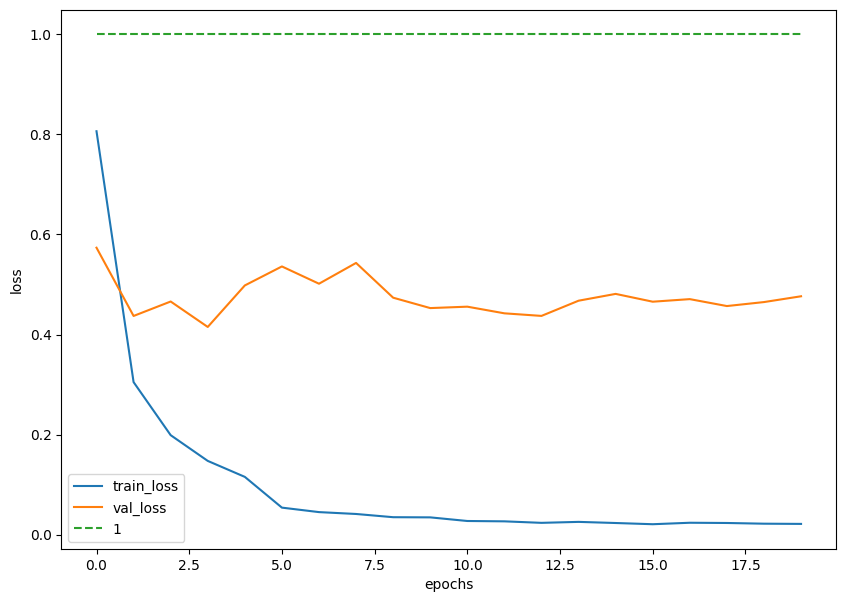

In [39]:
#LBL3
plt.figure(figsize=(10, 7))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.plot(np.ones(np.shape(val_loss)), ls='--', label="1")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

Пример тестирования модели на части набора данных:

In [ ]:
# evaluating model on 10% of test dataset
pred_1 = model.test_on_dataset(d_test, limit=0.1)
Metrics.print_all(d_test.labels[:len(pred_1)], pred_1, '10% of test')

outp: 
torch.Size([1800, 9])


inp: 
torch.Size([1800, 3, 224, 224])


metrics for 10% of test:
	 accuracy 0.9122:
	 balanced accuracy 0.9122:


Пример тестирования модели на полном наборе данных:

In [40]:
d_test_full = ImgDataset('test')

Downloading...
From (uriginal): https://drive.google.com/uc?id=1pCiol3n3Tj4jkPW-Sf6muqhGxkCE2LlK
From (redirected): https://drive.google.com/uc?id=1pCiol3n3Tj4jkPW-Sf6muqhGxkCE2LlK&confirm=t&uuid=e9e83fd4-284b-4063-8c2c-7b9eded827a7
To: /content/test.npz
100%|██████████| 525M/525M [00:12<00:00, 41.8MB/s]


Loading dataset test from npz.
Done. Dataset test consists of 4500 images.


In [41]:
# evaluating model on full test dataset (may take time)
if TEST_ON_LARGE_DATASET:
    pred_2 = model.test_on_dataset(d_test_full)
    Metrics.print_all(d_test_full.labels, pred_2, 'test')

outp: 
torch.Size([4500, 9])


inp: 
torch.Size([4500, 3, 224, 224])


metrics for test:
	 accuracy 0.9542:
	 balanced accuracy 0.9542:


Результат работы пайплайна обучения и тестирования выше тоже будет оцениваться. Поэтому не забудьте присылать на проверку ноутбук с выполнеными ячейками кода с демонстрациями метрик обучения, графиками и т.п. В этом пайплайне Вам необходимо продемонстрировать работу всех реализованных дополнений, улучшений и т.п.

<font color="red">
Настоятельно рекомендуется после получения пайплайна с полными результатами обучения экспортировать ноутбук в pdf (файл -> печать) и прислать этот pdf вместе с самим ноутбуком.
</font>

### Тестирование модели на других наборах данных

Ваша модель должна поддерживать тестирование на других наборах данных. Для удобства, Вам предоставляется набор данных test_tiny, который представляет собой малую часть (2% изображений) набора test. Ниже приведен фрагмент кода, который будет осуществлять тестирование для оценивания Вашей модели на дополнительных тестовых наборах данных.

<font color="red">
Прежде чем отсылать задание на проверку, убедитесь в работоспособности фрагмента кода ниже.
</font>

In [42]:
final_model = Model()
final_model.load('best_during_training')
d_test_tiny = ImgDataset('test_tiny')
pred = model.test_on_dataset(d_test_tiny)
Metrics.print_all(d_test_tiny.labels, pred, 'test-tiny')

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading...
From: https://drive.google.com/uc?id=1-2h3QHip_3sqJZmCJ-_wauwuRL38FWHc
To: /content/best.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 61.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=18e8gzRxqBLGHoyTwRwO3SCf_kAITLE07
To: /content/test_tiny.npz
100%|██████████| 10.6M/10.6M [00:00<00:00, 52.1MB/s]


Loading dataset test_tiny from npz.
Done. Dataset test_tiny consists of 90 images.
outp: 
torch.Size([90, 9])


inp: 
torch.Size([90, 3, 224, 224])


metrics for test-tiny:
	 accuracy 0.9556:
	 balanced accuracy 0.9556:


In [43]:
final_model = Model()
final_model.load('best_during_training')
pred = model.test_on_dataset(d_test_tiny)
Metrics.print_all(d_test_tiny.labels, pred, 'test-tiny')

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading...
From: https://drive.google.com/uc?id=1ZrjaKVxuGRZQ3-3IGSXPPileDNca2OID
To: /content/best_during_training.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 61.0MB/s]

outp: 
torch.Size([90, 9])


inp: 
torch.Size([90, 3, 224, 224])


metrics for test-tiny:
	 accuracy 0.9556:
	 balanced accuracy 0.9556:


Отмонтировать Google Drive.

In [ ]:
drive.flush_and_unmount()

---
# Дополнительные "полезности"

Ниже приведены примеры использования различных функций и библиотек, которые могут быть полезны при выполнении данного практического задания.

### Измерение времени работы кода

Измерять время работы какой-либо функции можно легко и непринужденно при помощи функции timeit из соответствующего модуля:

In [ ]:
import timeit

def factorial(n):
    res = 1
    for i in range(1, n + 1):
        res *= i
    return res


def f():
    return factorial(n=1000)

n_runs = 128
print(f'Function f is caluclated {n_runs} times in {timeit.timeit(f, number=n_runs)}s.')

### Scikit-learn

Для использования "классических" алгоритмов машинного обучения рекомендуется использовать библиотеку scikit-learn (https://scikit-learn.org/stable/). Пример классификации изображений цифр из набора данных MNIST при помощи классификатора SVM:

In [ ]:
# Standard scientific Python imports
import matplotlib.pyplot as plt

# Import datasets, classifiers and performance metrics
from sklearn import datasets, svm, metrics
from sklearn.model_selection import train_test_split

# The digits dataset
digits = datasets.load_digits()

# The data that we are interested in is made of 8x8 images of digits, let's
# have a look at the first 4 images, stored in the `images` attribute of the
# dataset.  If we were working from image files, we could load them using
# matplotlib.pyplot.imread.  Note that each image must have the same size. For these
# images, we know which digit they represent: it is given in the 'target' of
# the dataset.
_, axes = plt.subplots(2, 4)
images_and_labels = list(zip(digits.images, digits.target))
for ax, (image, label) in zip(axes[0, :], images_and_labels[:4]):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    ax.set_title('Training: %i' % label)

# To apply a classifier on this data, we need to flatten the image, to
# turn the data in a (samples, feature) matrix:
n_samples = len(digits.images)
data = digits.images.reshape((n_samples, -1))

# Create a classifier: a support vector classifier
classifier = svm.SVC(gamma=0.001)

# Split data into train and test subsets
X_train, X_test, y_train, y_test = train_test_split(
    data, digits.target, test_size=0.5, shuffle=False)

# We learn the digits on the first half of the digits
classifier.fit(X_train, y_train)

# Now predict the value of the digit on the second half:
predicted = classifier.predict(X_test)

images_and_predictions = list(zip(digits.images[n_samples // 2:], predicted))
for ax, (image, prediction) in zip(axes[1, :], images_and_predictions[:4]):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    ax.set_title('Prediction: %i' % prediction)

print("Classification report for classifier %s:\n%s\n"
      % (classifier, metrics.classification_report(y_test, predicted)))
disp = metrics.plot_confusion_matrix(classifier, X_test, y_test)
disp.figure_.suptitle("Confusion Matrix")
print("Confusion matrix:\n%s" % disp.confusion_matrix)

plt.show()

### Scikit-image

Реализовывать различные операции для работы с изображениями можно как самостоятельно, работая с массивами numpy, так и используя специализированные библиотеки, например, scikit-image (https://scikit-image.org/). Ниже приведен пример использования Canny edge detector.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi

from skimage import feature


# Generate noisy image of a square
im = np.zeros((128, 128))
im[32:-32, 32:-32] = 1

im = ndi.rotate(im, 15, mode='constant')
im = ndi.gaussian_filter(im, 4)
im += 0.2 * np.random.random(im.shape)

# Compute the Canny filter for two values of sigma
edges1 = feature.canny(im)
edges2 = feature.canny(im, sigma=3)

# display results
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(8, 3),
                                    sharex=True, sharey=True)

ax1.imshow(im, cmap=plt.cm.gray)
ax1.axis('off')
ax1.set_title('noisy image', fontsize=20)

ax2.imshow(edges1, cmap=plt.cm.gray)
ax2.axis('off')
ax2.set_title(r'Canny filter, $\sigma=1$', fontsize=20)

ax3.imshow(edges2, cmap=plt.cm.gray)
ax3.axis('off')
ax3.set_title(r'Canny filter, $\sigma=3$', fontsize=20)

fig.tight_layout()

plt.show()

### Tensorflow 2

Для создания и обучения нейросетевых моделей можно использовать фреймворк глубокого обучения Tensorflow 2. Ниже приведен пример простейшей нейроной сети, использующейся для классификации изображений из набора данных MNIST.

In [ ]:
# Install TensorFlow

import tensorflow as tf

mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(x_train, y_train, epochs=5)

model.evaluate(x_test,  y_test, verbose=2)

<font color="red">
Для эффективной работы с моделями глубокого обучения убедитесь в том, что в текущей среде Google Colab используется аппаратный ускоритель GPU или TPU. Для смены среды выберите "среда выполнения" -> "сменить среду выполнения".
</font>

Большое количество туториалов и примеров с кодом на Tensorflow 2 можно найти на официальном сайте https://www.tensorflow.org/tutorials?hl=ru.

Также, Вам может понадобиться написать собственный генератор данных для Tensorflow 2. Скорее всего он будет достаточно простым, и его легко можно будет реализовать, используя официальную документацию TensorFlow 2. Но, на всякий случай (если не удлось сразу разобраться или хочется вникнуть в тему более глубоко), можете посмотреть следующий отличный туториал: https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly.

### Numba

В некоторых ситуациях, при ручных реализациях графовых алгоритмов, выполнение многократных вложенных циклов for в python можно существенно ускорить, используя JIT-компилятор Numba (https://numba.pydata.org/).
Примеры использования Numba в Google Colab можно найти тут:
1. https://colab.research.google.com/github/cbernet/maldives/blob/master/numba/numba_cuda.ipynb
2. https://colab.research.google.com/github/evaneschneider/parallel-programming/blob/master/COMPASS_gpu_intro.ipynb

> Пожалуйста, если Вы решили использовать Numba для решения этого практического задания, еще раз подумайте, нужно ли это Вам, и есть ли возможность реализовать требуемую функциональность иным способом. Используйте Numba только при реальной необходимости.



### Работа с zip архивами в Google Drive

Запаковка и распаковка zip архивов может пригодиться при сохранении и загрузки Вашей модели. Ниже приведен фрагмент кода, иллюстрирующий помещение нескольких файлов в zip архив с последующим чтением файлов из него. Все действия с директориями, файлами и архивами должны осущетвляться с примонтированным Google Drive.


Создадим 2 изображения, поместим их в директорию tmp внутри PROJECT_DIR, запакуем директорию tmp в архив tmp.zip.

In [ ]:
PROJECT_DIR = "/dev/prak_nn_1/"
arr1 = np.random.rand(100, 100, 3) * 255
arr2 = np.random.rand(100, 100, 3) * 255

img1 = Image.fromarray(arr1.astype('uint8'))
img2 = Image.fromarray(arr2.astype('uint8'))

p = "/content/drive/MyDrive/" + PROJECT_DIR

if not (Path(p) / 'tmp').exists():
    (Path(p) / 'tmp').mkdir()

img1.save(str(Path(p) / 'tmp' / 'img1.png'))
img2.save(str(Path(p) / 'tmp' / 'img2.png'))

%cd $p
!zip -r "tmp.zip" "tmp"

Распакуем архив tmp.zip в директорию tmp2 в PROJECT_DIR. Теперь внутри директории tmp2 содержится директория tmp, внутри которой находятся 2 изображения.

In [ ]:
p = "/content/drive/MyDrive/" + PROJECT_DIR
%cd $p
!unzip -uq "tmp.zip" -d "tmp2"